In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.validation import VALIDATION_NAMES, VALIDATION_ABBRVS
from thesispy.definitions import *
from thesispy.plot_utils import *
from thesispy.elastix_wrapper.wrapper import run
from thesispy.elastix_wrapper.parameters import Parameters
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.image as mpimg
import numpy as np
from scipy.stats import ttest_ind

In [ ]:
moving_img = mpimg.imread(INSTANCES_SRC / "examples" / "scans" / "01_Moving.png")
fixed_img = mpimg.imread(INSTANCES_SRC / "examples" / "scans" / "01_Fixed.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(moving_img, cmap="gray")
axes[0].set_title("Moving")

axes[1].imshow(fixed_img, cmap="gray")
axes[1].set_title("Fixed")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("trivial_registration.pdf")

In [ ]:
params = Parameters.from_base(mesh_size=5).asgd().stopping_criteria(iterations=10000).instance(Collection.EXAMPLES, 1)
run_result = run(params, Path("output/" + str(params)), suppress_stdout=False, visualize=False, validate=True)

In [ ]:
from thesispy.experiments.validation import *

plt.figure(figsize=(7, 7))
plot_dvf(run_result.dvf, scale=5)
plt.savefig("trivial_dvf.pdf")

In [ ]:
plt.figure(figsize=(7, 7))
plt.imshow(run_result.deformed, cmap="gray")
plt.savefig("trivial_deformed.pdf")

In [ ]:
iteration_output = np.loadtxt(Path("output") / "1669219915_examples_1_adaptivestochasticgradientdescent_16598" / "out" / "IterationInfo.0.R0.txt", skiprows=1)
missed_pixels = iteration_output[:, 2]

In [ ]:
from thesispy.plot_utils import *

plt.figure(figsize=(7, 7))
plt.plot(missed_pixels)
plt.xlabel("Iteration")
plt.ylabel("Missed voxels (\%)")

plt.savefig("trivial_missedvoxels.pdf")

In [2]:
ds = get_runs_as_dataset("synthetic_1_constrained_selection")

In [3]:
arrs = ds.aggregate_for_plot(["UseConstraints", "MissedPixelConstraintThreshold"])
arrs_mp = ds.aggregate_for_plot(["UseConstraints", "MissedPixelConstraintThreshold"], metric="missedpixels")

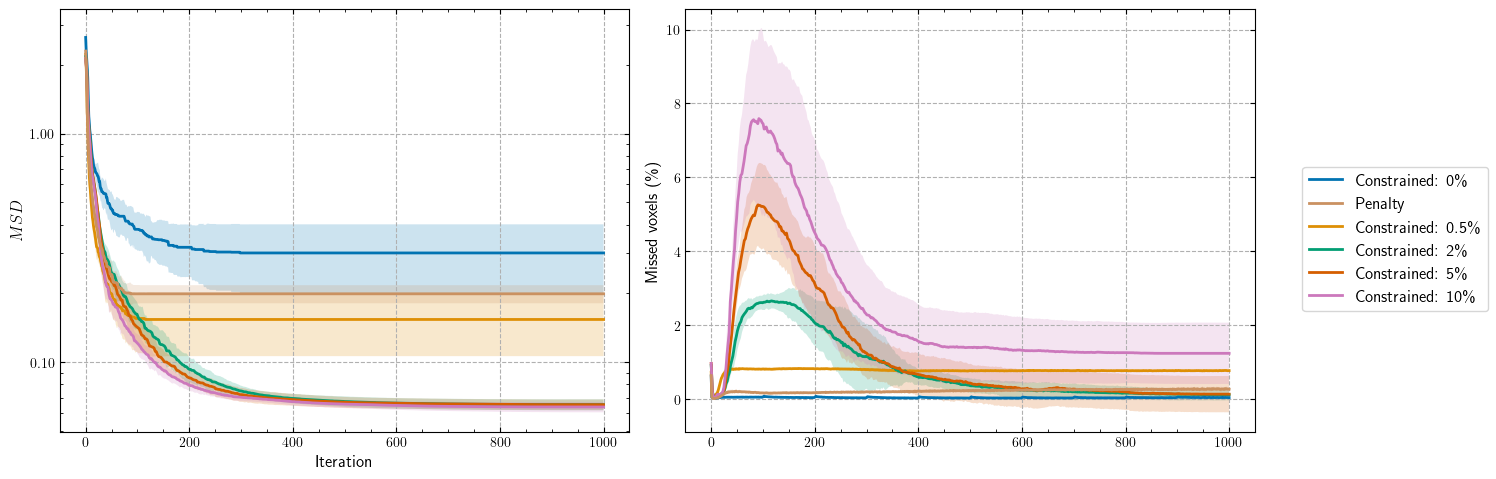

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for use_constraints in [True, False]:
    for i, constraints_threshold in enumerate([0, 0.5, 2, 5, 10]):
        if not use_constraints and i > 0:
            continue

        arr_avg, arr_median, arr_std = arrs[(use_constraints, constraints_threshold)]
        xs = np.linspace(0, 1000, len(arr_median))
        label = f"Constrained: {constraints_threshold}\%" if use_constraints else "Penalty"
        axes[0].plot(xs, arr_median, label=label)
        axes[0].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)

        arr_avg, arr_median, arr_std = arrs_mp[(use_constraints, constraints_threshold)]
        xs = np.linspace(0, 1000, len(arr_median))
        axes[1].plot(xs, arr_median, label=label)
        axes[1].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)
    
        # formatting
        axes[0].set_yscale("log")
        axes[0].yaxis.set_major_formatter(formatter)
        axes[0].set_xlabel("Iteration", fontsize=12)
        axes[0].set_ylabel("$MSD$", fontsize=12)
        axes[1].set_ylabel("Missed voxels (\%)", fontsize=12)


handles, labels = axes[0].get_legend_handles_labels()
order = [0, 5, 1, 2, 3, 4]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(handles, labels, ncol=1, loc="center right", prop={'size': 12})
plt.tight_layout(rect=[0, 0.02, 0.85, 1])
plt.savefig("constrained_selection_iterations.pdf")